<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/research_nsfnet_adaptive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3 MB 21 kB/s 
     |████████████████████████████████| 503 kB 26.1 MB/s 
     |████████████████████████████████| 50 kB 3.9 MB/s 
     |████████████████████████████████| 3.8 MB 33.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7d68355ffa9483d67ca553c0c08fa1e41fc3c8bcb7bb606f5dd3298e6d682e36
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import pickle

In [ ]:


# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, x0, y0, t0, u0, v0, xb, yb, tb, ub, vb, x, y, t, layers):
        X0 = np.concatenate([x0, y0, t0], 1)  # remove the second bracket
        Xb = np.concatenate([xb, yb, tb], 1)
        X = np.concatenate([x, y, t], 1)

        self.lowb = X.min(0)  # minimal number in each column
        self.upb = X.max(0)

        self.X0 = X0
        self.Xb = Xb
        self.X = X

        self.x0 = X0[:, 0:1]
        self.y0 = X0[:, 1:2]
        self.t0 = X0[:, 2:3]
        self.xb = Xb[:, 0:1]
        self.yb = Xb[:, 1:2]
        self.tb = Xb[:, 2:3]
        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.t = X[:, 2:3]

        self.u0 = u0
        self.v0 = v0
        self.ub = ub
        self.vb = vb

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])

        self.encoder_weights_1=self.xavier_init([3,layers[1]])
        self.encoder_biases_1=self.xavier_init([1,layers[1]])

        self.encoder_weights_2=self.xavier_init([3,layers[1]])
        self.encoder_biases_2=self.xavier_init([1,layers[1]])

        # Adaptive re-weighting constants
        self.beta=0.9
        self.adaptive_constant_bcs_val=np.array(1.0) # arw for boundary conditions
        self.adaptive_constant_ics_val=np.array(1.0) # arw for initial conditions


        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.x_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.vb.shape[1]])

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)

        # Evaluating predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        # Defining loss functions for boundary conditions and initial conditions

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.u_boundary_tf - self.u_boundary_pred)) + tf.reduce_mean(tf.square(self.v_boundary_tf - self.v_boundary_pred)))

        self.loss_ics=self.adaptive_constant_ics_tf*(tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)))
        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs + self.loss_ics

        # Deifining optimizer with learning rate schedule
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        
        for i in range(len(self.layers)-1):
          self.grads_res.append(tf.gradients(self.loss_res,self.weights[i][0]))
          self.grads_bcs.append(tf.gradients(self.loss_bcs,self.weights[i][0]))
          self.grads_ics.append(tf.gradients(self.loss_ics,self.weights[i][0]))
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              (tf.reduce_max(tf.abs(self.grad_res[i]))) / (tf.reduce_mean(tf.abs(self.grad_bcs[i])))
          )
          self.adaptive_constant_ics_list.append(
              (tf.reduce_max(tf.abs(self.grad_res[i]))) / (tf.reduce_mean(tf.abs(self.grad_ics[i])))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adpative_constant_ics=tf.reduce_max(tf.stack(self.adaptive_constatn_ics_list))
        
        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)


# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# saving the weights and biases for transfer learning
    def save_parameters(self,fileDr):
      weights=self.sess.run(self.weights)
      biases= self.sess.run(self.biases)

      with open(fileDr,'wb') as f:
        pickle.dump([weights,biases],f)
        print("Parameters are saved in pickle file")
        
# loading the weights and biases for transfer learning
    def load_parameters(self,fileDr,layers):
      weights=[]
      biases=[]
      num_layers=len(layers)

      with open(fileDr,'rb') as f:
        weights,biases=pickle.load(f)

        assert num_layers == (len(weights)+1)

        for num in range(0,num_layers-1):
          W=tf.Variable(weights[num])
          b=tf.Variable(biases[num])
          weights.append(W)
          biases.append(b)
        print("Parameters are loaded succesffuly")
      return weights,biases

# generate the neural network
    def neural_net(self, X):
        num_layers = len(self.layers)
        H = X
        # H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        encoder_1= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_1),self.encoder_biases_1))
        encoder_2= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_2),self.encoder_biases_2))
        
        for l in range(0, num_layers - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_1)+ tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_2)
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

# tf_dict is used to connect model variable and data

    def Adam_train(self, nIter=5000):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                   self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
# later here should add dynamic strategy here
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                start_time = time.time()

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:

if __name__ == "__main__":

    N_train = 14000

    layers = [3, 20, 20, 20, 20,20,20,20,20 , 2]

    # Load Data
    # path=r"C:\Users\Admin\Downloads\all_pressures"
    path=r"/content/drive/MyDrive/all_pressures"
    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)


    data1=np.concatenate([x ,y ,t , u , v ,p ],1)
    data2=data1[:,:][data1[:,2]<=7]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]
    data_domain=data5[:,:][data5[:,1]<=ymax]

    data_t0=data_domain[:,:][data_domain[:,2]==0]

    data_y1=data_domain[:,:][data_domain[:,0]==xmin]
    data_y8=data_domain[:,:][data_domain[:,0]==xmax]
    data_x=data_domain[:,:][data_domain[:,1]==ymin]
    data_x2=data_domain[:,:][data_domain[:,1]==ymax]

    data_sup_b_train = np.concatenate([data_y1, data_y8, data_x, data_x2], 0)

    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)

    x_train = data_domain[idx, 0].reshape(data_domain[idx, 0].shape[0], 1)
    y_train = data_domain[idx, 1].reshape(data_domain[idx, 1].shape[0], 1)
    t_train = data_domain[idx, 2].reshape(data_domain[idx, 2].shape[0], 1)

    x0_train = data_t0[:, 0].reshape(data_t0[:, 0].shape[0], 1)
    y0_train = data_t0[:, 1].reshape(data_t0[:, 1].shape[0], 1)
    t0_train = data_t0[:, 2].reshape(data_t0[:, 2].shape[0], 1)
    u0_train = data_t0[:, 3].reshape(data_t0[:, 3].shape[0], 1)
    v0_train = data_t0[:, 4].reshape(data_t0[:, 4].shape[0], 1)

    xb_train = data_sup_b_train[:, 0].reshape(data_sup_b_train[:, 0].shape[0], 1)
    yb_train = data_sup_b_train[:, 1].reshape(data_sup_b_train[:, 1].shape[0], 1)
    tb_train = data_sup_b_train[:, 2].reshape(data_sup_b_train[:, 2].shape[0], 1)
    ub_train = data_sup_b_train[:, 3].reshape(data_sup_b_train[:, 3].shape[0], 1)
    vb_train = data_sup_b_train[:, 4].reshape(data_sup_b_train[:, 4].shape[0], 1)

    model =     pinn(x0_train, y0_train, t0_train, u0_train, v0_train, xb_train,
                     yb_train, tb_train, ub_train, vb_train, x_train, y_train, t_train,
                     layers)

    model.Adam_train(5000)
    model.Adam_train(5000)
    model.Adam_train(50000)
    model.Adam_train(50000)
    model.BFGS_train()

    # Test Data
    snap = np.array([100])
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]

    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]

    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

    # Error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
    error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Predicted Velocity

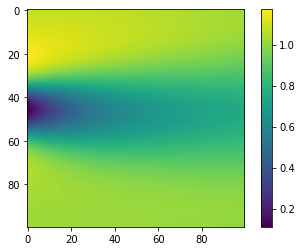

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

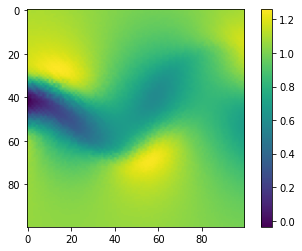

In [ ]:
upl=np.reshape(u_star,(100,100))
plt.imshow(upl)
plt.colorbar()